In [16]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

2024-05-14 11:05:16.290963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [11]:
test_split = 0.2

### START YOUR CODE
# Shuffle and split names data

names = names.sample(frac=1).reset_index(drop=True)
train = names[:int(len(names)*(1-test_split))]
test = names[int(len(names)*(1-test_split)):]

### END YOUR CODE

In [12]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = np.array([name_representation(name, maxlen) for name in train.name])
Y_train = np.array([lang_representation(lang, language_to_index) for lang in train.lang])

X_test = np.array([name_representation(name, maxlen) for name in test.name])
Y_test = np.array([lang_representation(lang, language_to_index) for lang in test.lang])

### END YOUR CODE

### Utilities

In [13]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [20]:
import sklearn
import pandas as pd

def compute_confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [17]:
### START YOUR CODE

# SImpleRNN, single layer with tf.keras....

model = Sequential()
model.add(SimpleRNN(128, input_shape=(maxlen, len_alphabet)))
model.add(Dense(len(languages), activation='softmax'))

### END YOUR CODE

2024-05-14 11:05:34.253483: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: AMD Radeon Pro 5300M
2024-05-14 11:05:34.253902: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-14 11:05:34.253923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 1.99 GB
2024-05-14 11:05:34.255134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-14 11:05:34.255924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
### START YOUR CODE
batch_size=64
nepochs = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nepochs, batch_size=batch_size)

### END YOUR CODE

Epoch 1/10


2024-05-14 11:06:10.714753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-14 11:06:10.865703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


71/71 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6507

2024-05-14 11:06:41.891623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 34s 437ms/step - loss: 1.0461 - accuracy: 0.6507 - val_loss: 0.8836 - val_accuracy: 0.6919
Epoch 2/10
71/71 [==============================] - 30s 424ms/step - loss: 0.8263 - accuracy: 0.7020 - val_loss: 0.7595 - val_accuracy: 0.7280
Epoch 3/10
71/71 [==============================] - 28s 391ms/step - loss: 0.7342 - accuracy: 0.7392 - val_loss: 0.7040 - val_accuracy: 0.7465
Epoch 4/10
71/71 [==============================] - 30s 424ms/step - loss: 0.7010 - accuracy: 0.7480 - val_loss: 0.6841 - val_accuracy: 0.7509
Epoch 5/10
71/71 [==============================] - 32s 456ms/step - loss: 0.6682 - accuracy: 0.7601 - val_loss: 0.7022 - val_accuracy: 0.7412
Epoch 6/10
71/71 [==============================] - 31s 430ms/step - loss: 0.6264 - accuracy: 0.7780 - val_loss: 0.6543 - val_accuracy: 0.7606
Epoch 7/10
71/71 [==============================] - 30s 424ms/step - loss: 0.6137 - accuracy: 0.7784 - val_loss: 0.6507 - val_accuracy: 0.7597
Epoch 8/10

Train accuracy (end): 0.8066079020500183
Train accuracy (max): 0.8081497550010681
Test accuracy (end) : 0.7896126508712769
Test accuracy (max) : 0.7896126508712769


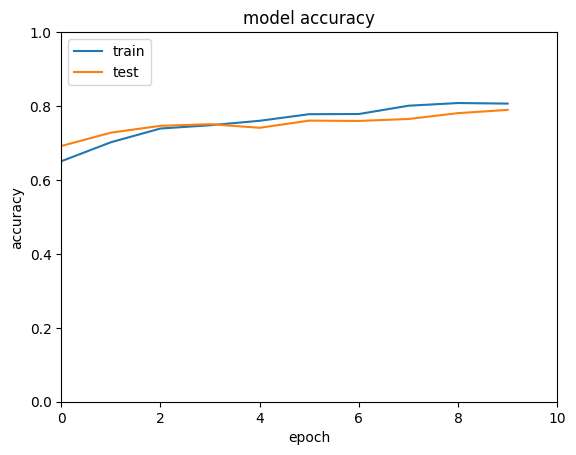

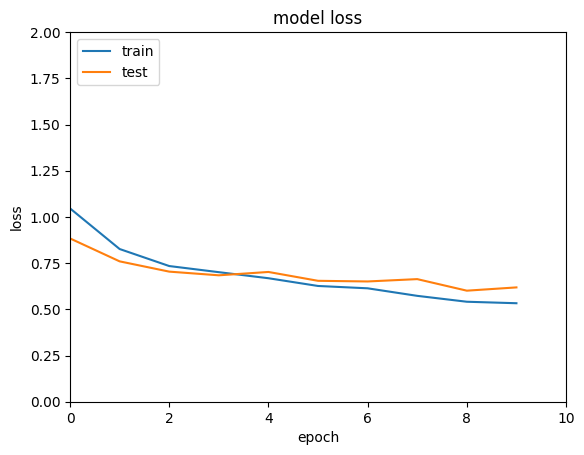

 1/36 [..............................] - ETA: 11s

2024-05-14 11:14:41.595887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 79ms/step


,English,French,Italian,German,Spanish
English,66,1,76,0,2
French,2,5,44,2,5
Italian,14,0,729,1,13
German,0,3,23,9,12
Spanish,2,1,34,4,88


In [21]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = compute_confusion_matrix(model, X_test, Y_test)
df

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [22]:
def handle_imbalance(names, languages):

    ### START YOUR CODE

    # treat class imbalance
    # upsample the minority classes
    # get the number of samples in each class
    n_samples = names.groupby('lang')['name'].count()
    max_samples = n_samples.max()
    names_upsampled = names.copy()
    for lang in languages:
        lang_samples = names[names['lang'] == lang]
        n_samples = lang_samples.shape[0]
        if n_samples < max_samples:
            n_samples_to_add = max_samples - n_samples
            samples_to_add = lang_samples.sample(n=n_samples_to_add, replace=True)
            names_upsampled = pd.concat([names_upsampled, samples_to_add])

    ### END YOUR CODE    
    return names_upsampled


In [23]:
names_upsampled = handle_imbalance(names, languages)
names_upsampled.groupby('lang')['name'].count()/len(names_upsampled)

lang
English    0.2
French     0.2
German     0.2
Italian    0.2
Spanish    0.2
Name: name, dtype: float64

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [24]:
### START YOUR CODE

X_train = np.array([name_representation(name, maxlen) for name in names_upsampled.name])
Y_train = np.array([lang_representation(lang, language_to_index) for lang in names_upsampled.lang])

X_test = np.array([name_representation(name, maxlen) for name in test.name])
Y_test = np.array([lang_representation(lang, language_to_index) for lang in test.lang])

### END YOUR CODE

Epoch 1/10


2024-05-14 11:16:22.530853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-14 11:16:22.742394: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


287/287 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.5724

2024-05-14 11:18:07.800222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


287/287 [==============================] - 108s 368ms/step - loss: 1.0494 - accuracy: 0.5724 - val_loss: 0.8748 - val_accuracy: 0.6461
Epoch 2/10
287/287 [==============================] - 95s 330ms/step - loss: 0.7213 - accuracy: 0.7261 - val_loss: 0.7844 - val_accuracy: 0.6725
Epoch 3/10
287/287 [==============================] - 95s 329ms/step - loss: 0.5248 - accuracy: 0.8079 - val_loss: 0.5442 - val_accuracy: 0.7896
Epoch 4/10
287/287 [==============================] - 89s 309ms/step - loss: 0.3840 - accuracy: 0.8638 - val_loss: 0.5654 - val_accuracy: 0.7738
Epoch 5/10
287/287 [==============================] - 95s 331ms/step - loss: 0.3026 - accuracy: 0.8965 - val_loss: 0.4727 - val_accuracy: 0.8204
Epoch 6/10
287/287 [==============================] - 99s 343ms/step - loss: 0.2653 - accuracy: 0.9101 - val_loss: 0.3060 - val_accuracy: 0.8996
Epoch 7/10
287/287 [==============================] - 99s 345ms/step - loss: 0.2366 - accuracy: 0.9221 - val_loss: 0.2905 - val_accuracy: 0.

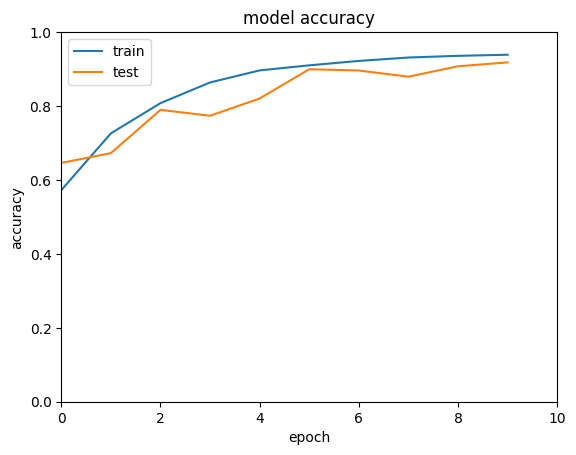

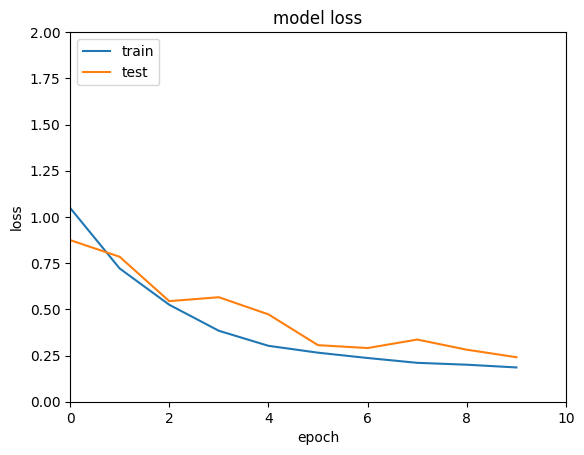

 1/36 [..............................] - ETA: 9s

2024-05-14 11:32:39.832517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 62ms/step


,English,French,Italian,German,Spanish
English,136,4,4,1,0
French,0,55,3,0,0
Italian,29,19,685,11,13
German,0,0,1,44,2
Spanish,0,0,0,6,123


In [25]:
### START YOUR CODE

# train model

model = Sequential()
model.add(SimpleRNN(128, input_shape=(maxlen, len_alphabet)))
model.add(Dense(len(languages), activation='softmax'))

batch_size=64
nepochs = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nepochs, batch_size=batch_size)

performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = compute_confusion_matrix(model, X_test, Y_test)
df

### END YOUR CODE

#### Findings

...


#### In which situations is class imbalance treatment important and why?  

....

### Implement Model with several SimpleRNN Layers

In [ ]:
### START YOUR CODE

# using several simpleRNN layers
model = Sequential()
model.add(SimpleRNN(128, input_shape=(maxlen, len_alphabet), return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(len(languages), activation='softmax'))

### END YOUR CODE

model.summary()

In [ ]:
### START YOUR CODE

# train
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nepochs, batch_size=batch_size)

performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = compute_confusion_matrix(model, X_test, Y_test)
df

### END YOUR CODE

#### Findings

...
